## Import necessary Libraires

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import time
from pathlib import Path
import shutil
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# Uncomment for google Colab usage

In [21]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Put your directory path here.

In [2]:
data_dir = 'F:/MY DEEP LEARNING AND ML JOURNEY/Deep Learning/Projects/Potato_classifications/PlantVillage'
base_dir = 'F:/MY DEEP LEARNING AND ML JOURNEY/Deep Learning/Projects/Potato_classifications/Plant_disease_clf/dataset_split/'
os.listdir(data_dir)

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Spliting Dataset into-
Train - 60%,
Test - 20%,
Valid - 20%

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok = True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in tqdm(os.listdir(data_dir)):
  cls_dir = os.path.join(data_dir, cls)
  if not os.path.isdir(cls_dir):
    continue
  images = os.listdir(cls_dir)
  train_images , test_images = train_test_split(images, test_size = 0.4, random_state=42)
  val_images , test_images = train_test_split(test_images, test_size = 0.5, random_state = 42)

  os.makedirs(os.path.join(train_dir,cls),exist_ok = True)
  os.makedirs(os.path.join(val_dir,cls),exist_ok = True)
  os.makedirs(os.path.join(test_dir,cls),exist_ok = True)

  for img in train_images:
    shutil.copy(os.path.join(cls_dir,img), os.path.join(train_dir,cls,img))
  for img in val_images:
    shutil.copy(os.path.join(cls_dir,img), os.path.join(val_dir,cls,img))
  for img in test_images:
    shutil.copy(os.path.join(cls_dir,img), os.path.join(test_dir,cls,img))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:52<00:00, 15.49s/it]


## Applying Data Augmentation Techniques

In [26]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.15,saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])

In [27]:
train_data = datasets.ImageFolder(root=train_dir, transform = transform)
val_data = datasets.ImageFolder(root=val_dir, transform = transform)
test_data = datasets.ImageFolder(root=test_dir, transform = transform)

# Load our datasets into DataLoader

In [44]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True, num_workers=2)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = False, num_workers=2)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = False, num_workers=2)

In [12]:
classes = train_data.classes
print(classes)
print(len(classes))

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
15


## Transfer Learning ( ResNet50 )

<p> Experimenting by Freezing all ResNet layer. Better approach is to unfreeze last few layers for fine-tuning</p>

In [15]:
model = models.resnet50(weights='IMAGENET1K_V2')

In [46]:
for param in model.parameters():
  param.requires_grad = False

In [47]:
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 50

for epoch in tqdm(range(epochs)):
  model.train()
  train_loss , train_acc = 0.0 , 0.0
  val_loss , val_acc = 0.0 , 0.0
  correct , total = 0, 0

  for X, y in train_loader:

    X , y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct += (y_pred.argmax(1)==y).sum().item()
    total += y.size(0)


  train_acc += 100* correct/total
  train_loss /= len(train_loader)

  model.eval()
  with torch.no_grad():
    for X, y in val_loader:
      X , y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      val_loss += loss.item()
      correct = (y_pred.argmax(1)==y).sum().item()
      total = y.size(0)
  val_acc += 100* correct/total
  val_loss /= len(val_loader)

  print(f"Epoch [{epoch+1}/{epochs}] | Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Val loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")


  2%|▏         | 1/50 [02:21<1:55:14, 141.11s/it]

Epoch [1/50] | Train loss: 2.0835 | Train Accuracy: 47.96% | Val loss: 1.8430 | Val Accuracy: 75.76%


  4%|▍         | 2/50 [04:44<1:54:08, 142.67s/it]

Epoch [2/50] | Train loss: 1.6558 | Train Accuracy: 68.23% | Val loss: 1.4955 | Val Accuracy: 96.97%


  6%|▌         | 3/50 [07:20<1:56:14, 148.39s/it]

Epoch [3/50] | Train loss: 1.3731 | Train Accuracy: 74.08% | Val loss: 1.2566 | Val Accuracy: 93.94%


  8%|▊         | 4/50 [09:30<1:48:24, 141.40s/it]

Epoch [4/50] | Train loss: 1.1750 | Train Accuracy: 78.18% | Val loss: 1.0788 | Val Accuracy: 96.97%


 10%|█         | 5/50 [11:41<1:43:03, 137.41s/it]

Epoch [5/50] | Train loss: 1.0360 | Train Accuracy: 80.01% | Val loss: 0.9802 | Val Accuracy: 93.94%


 12%|█▏        | 6/50 [13:50<1:38:42, 134.60s/it]

Epoch [6/50] | Train loss: 0.9271 | Train Accuracy: 82.32% | Val loss: 0.8805 | Val Accuracy: 100.00%


 14%|█▍        | 7/50 [15:57<1:34:39, 132.09s/it]

Epoch [7/50] | Train loss: 0.8468 | Train Accuracy: 83.57% | Val loss: 0.8218 | Val Accuracy: 100.00%


 16%|█▌        | 8/50 [18:03<1:31:04, 130.11s/it]

Epoch [8/50] | Train loss: 0.7742 | Train Accuracy: 84.74% | Val loss: 0.7338 | Val Accuracy: 100.00%


 18%|█▊        | 9/50 [20:08<1:27:56, 128.69s/it]

Epoch [9/50] | Train loss: 0.7101 | Train Accuracy: 86.07% | Val loss: 0.6709 | Val Accuracy: 96.97%


 20%|██        | 10/50 [22:13<1:24:58, 127.47s/it]

Epoch [10/50] | Train loss: 0.6714 | Train Accuracy: 86.57% | Val loss: 0.6300 | Val Accuracy: 100.00%


 22%|██▏       | 11/50 [24:18<1:22:23, 126.77s/it]

Epoch [11/50] | Train loss: 0.6240 | Train Accuracy: 87.56% | Val loss: 0.6012 | Val Accuracy: 96.97%


 24%|██▍       | 12/50 [26:23<1:19:52, 126.12s/it]

Epoch [12/50] | Train loss: 0.5886 | Train Accuracy: 88.59% | Val loss: 0.5742 | Val Accuracy: 100.00%


 26%|██▌       | 13/50 [28:27<1:17:29, 125.67s/it]

Epoch [13/50] | Train loss: 0.5564 | Train Accuracy: 89.05% | Val loss: 0.5461 | Val Accuracy: 96.97%


 28%|██▊       | 14/50 [30:33<1:15:24, 125.69s/it]

Epoch [14/50] | Train loss: 0.5275 | Train Accuracy: 89.22% | Val loss: 0.5284 | Val Accuracy: 100.00%


 30%|███       | 15/50 [32:38<1:13:09, 125.41s/it]

Epoch [15/50] | Train loss: 0.5029 | Train Accuracy: 89.80% | Val loss: 0.4923 | Val Accuracy: 100.00%


 32%|███▏      | 16/50 [34:42<1:10:51, 125.05s/it]

Epoch [16/50] | Train loss: 0.4796 | Train Accuracy: 90.32% | Val loss: 0.4687 | Val Accuracy: 100.00%


 34%|███▍      | 17/50 [36:47<1:08:47, 125.06s/it]

Epoch [17/50] | Train loss: 0.4679 | Train Accuracy: 90.35% | Val loss: 0.4618 | Val Accuracy: 100.00%


 36%|███▌      | 18/50 [38:52<1:06:40, 125.02s/it]

Epoch [18/50] | Train loss: 0.4455 | Train Accuracy: 90.87% | Val loss: 0.4318 | Val Accuracy: 100.00%


 38%|███▊      | 19/50 [40:59<1:04:53, 125.61s/it]

Epoch [19/50] | Train loss: 0.4318 | Train Accuracy: 91.06% | Val loss: 0.4324 | Val Accuracy: 100.00%


 40%|████      | 20/50 [43:06<1:03:03, 126.13s/it]

Epoch [20/50] | Train loss: 0.4151 | Train Accuracy: 91.03% | Val loss: 0.3958 | Val Accuracy: 100.00%


 42%|████▏     | 21/50 [45:14<1:01:09, 126.53s/it]

Epoch [21/50] | Train loss: 0.3970 | Train Accuracy: 91.82% | Val loss: 0.3880 | Val Accuracy: 100.00%


 44%|████▍     | 22/50 [47:22<59:15, 126.99s/it]  

Epoch [22/50] | Train loss: 0.3838 | Train Accuracy: 91.85% | Val loss: 0.3837 | Val Accuracy: 100.00%


 46%|████▌     | 23/50 [49:29<57:13, 127.16s/it]

Epoch [23/50] | Train loss: 0.3686 | Train Accuracy: 92.42% | Val loss: 0.3735 | Val Accuracy: 100.00%


 48%|████▊     | 24/50 [51:38<55:14, 127.47s/it]

Epoch [24/50] | Train loss: 0.3609 | Train Accuracy: 92.29% | Val loss: 0.3670 | Val Accuracy: 100.00%


 50%|█████     | 25/50 [53:43<52:47, 126.71s/it]

Epoch [25/50] | Train loss: 0.3572 | Train Accuracy: 92.41% | Val loss: 0.3616 | Val Accuracy: 100.00%


 52%|█████▏    | 26/50 [55:48<50:35, 126.49s/it]

Epoch [26/50] | Train loss: 0.3483 | Train Accuracy: 92.73% | Val loss: 0.3490 | Val Accuracy: 100.00%


 54%|█████▍    | 27/50 [57:53<48:14, 125.84s/it]

Epoch [27/50] | Train loss: 0.3311 | Train Accuracy: 92.71% | Val loss: 0.3425 | Val Accuracy: 100.00%


 56%|█████▌    | 28/50 [59:59<46:08, 125.82s/it]

Epoch [28/50] | Train loss: 0.3328 | Train Accuracy: 92.69% | Val loss: 0.3261 | Val Accuracy: 100.00%


 58%|█████▊    | 29/50 [1:02:03<43:50, 125.27s/it]

Epoch [29/50] | Train loss: 0.3185 | Train Accuracy: 92.86% | Val loss: 0.3202 | Val Accuracy: 100.00%


 60%|██████    | 30/50 [1:04:07<41:40, 125.03s/it]

Epoch [30/50] | Train loss: 0.3078 | Train Accuracy: 93.18% | Val loss: 0.3143 | Val Accuracy: 100.00%


 62%|██████▏   | 31/50 [1:06:11<39:31, 124.83s/it]

Epoch [31/50] | Train loss: 0.2981 | Train Accuracy: 93.51% | Val loss: 0.3199 | Val Accuracy: 100.00%


 64%|██████▍   | 32/50 [1:08:15<37:21, 124.54s/it]

Epoch [32/50] | Train loss: 0.2987 | Train Accuracy: 93.49% | Val loss: 0.3091 | Val Accuracy: 100.00%


 66%|██████▌   | 33/50 [1:10:19<35:13, 124.35s/it]

Epoch [33/50] | Train loss: 0.2871 | Train Accuracy: 93.71% | Val loss: 0.3026 | Val Accuracy: 100.00%


 68%|██████▊   | 34/50 [1:12:24<33:13, 124.56s/it]

Epoch [34/50] | Train loss: 0.2798 | Train Accuracy: 94.01% | Val loss: 0.2933 | Val Accuracy: 100.00%


 70%|███████   | 35/50 [1:14:27<31:01, 124.10s/it]

Epoch [35/50] | Train loss: 0.2784 | Train Accuracy: 93.97% | Val loss: 0.2853 | Val Accuracy: 100.00%


 72%|███████▏  | 36/50 [1:16:31<28:54, 123.89s/it]

Epoch [36/50] | Train loss: 0.2691 | Train Accuracy: 94.17% | Val loss: 0.2928 | Val Accuracy: 100.00%


 74%|███████▍  | 37/50 [1:18:35<26:53, 124.09s/it]

Epoch [37/50] | Train loss: 0.2654 | Train Accuracy: 94.06% | Val loss: 0.2825 | Val Accuracy: 100.00%


 76%|███████▌  | 38/50 [1:20:38<24:43, 123.64s/it]

Epoch [38/50] | Train loss: 0.2586 | Train Accuracy: 94.34% | Val loss: 0.2741 | Val Accuracy: 100.00%


 78%|███████▊  | 39/50 [1:22:41<22:39, 123.63s/it]

Epoch [39/50] | Train loss: 0.2573 | Train Accuracy: 94.19% | Val loss: 0.2642 | Val Accuracy: 100.00%


 80%|████████  | 40/50 [1:24:45<20:34, 123.48s/it]

Epoch [40/50] | Train loss: 0.2523 | Train Accuracy: 94.57% | Val loss: 0.2643 | Val Accuracy: 100.00%


 82%|████████▏ | 41/50 [1:26:49<18:34, 123.83s/it]

Epoch [41/50] | Train loss: 0.2441 | Train Accuracy: 94.45% | Val loss: 0.2527 | Val Accuracy: 100.00%


 84%|████████▍ | 42/50 [1:28:53<16:30, 123.79s/it]

Epoch [42/50] | Train loss: 0.2424 | Train Accuracy: 94.48% | Val loss: 0.2575 | Val Accuracy: 100.00%


 86%|████████▌ | 43/50 [1:30:56<14:25, 123.58s/it]

Epoch [43/50] | Train loss: 0.2344 | Train Accuracy: 94.92% | Val loss: 0.2485 | Val Accuracy: 100.00%


 88%|████████▊ | 44/50 [1:33:00<12:22, 123.69s/it]

Epoch [44/50] | Train loss: 0.2352 | Train Accuracy: 94.85% | Val loss: 0.2502 | Val Accuracy: 100.00%


 90%|█████████ | 45/50 [1:35:03<10:16, 123.39s/it]

Epoch [45/50] | Train loss: 0.2277 | Train Accuracy: 94.89% | Val loss: 0.2416 | Val Accuracy: 100.00%


 92%|█████████▏| 46/50 [1:37:07<08:14, 123.54s/it]

Epoch [46/50] | Train loss: 0.2259 | Train Accuracy: 94.96% | Val loss: 0.2375 | Val Accuracy: 100.00%


 94%|█████████▍| 47/50 [1:39:10<06:10, 123.41s/it]

Epoch [47/50] | Train loss: 0.2209 | Train Accuracy: 95.05% | Val loss: 0.2506 | Val Accuracy: 100.00%


 96%|█████████▌| 48/50 [1:41:12<04:06, 123.02s/it]

Epoch [48/50] | Train loss: 0.2178 | Train Accuracy: 95.03% | Val loss: 0.2369 | Val Accuracy: 100.00%


 98%|█████████▊| 49/50 [1:43:15<02:02, 122.99s/it]

Epoch [49/50] | Train loss: 0.2183 | Train Accuracy: 95.15% | Val loss: 0.2359 | Val Accuracy: 100.00%


100%|██████████| 50/50 [1:45:18<00:00, 126.37s/it]

Epoch [50/50] | Train loss: 0.2111 | Train Accuracy: 95.23% | Val loss: 0.2306 | Val Accuracy: 100.00%


In [53]:
model.eval()

y_true , y_pred = [], []

with torch.no_grad():
  for X , y in test_loader:
    X,y = X.to(device), y.to(device)
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)

    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = (y_true == y_pred).mean()
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 93.61%


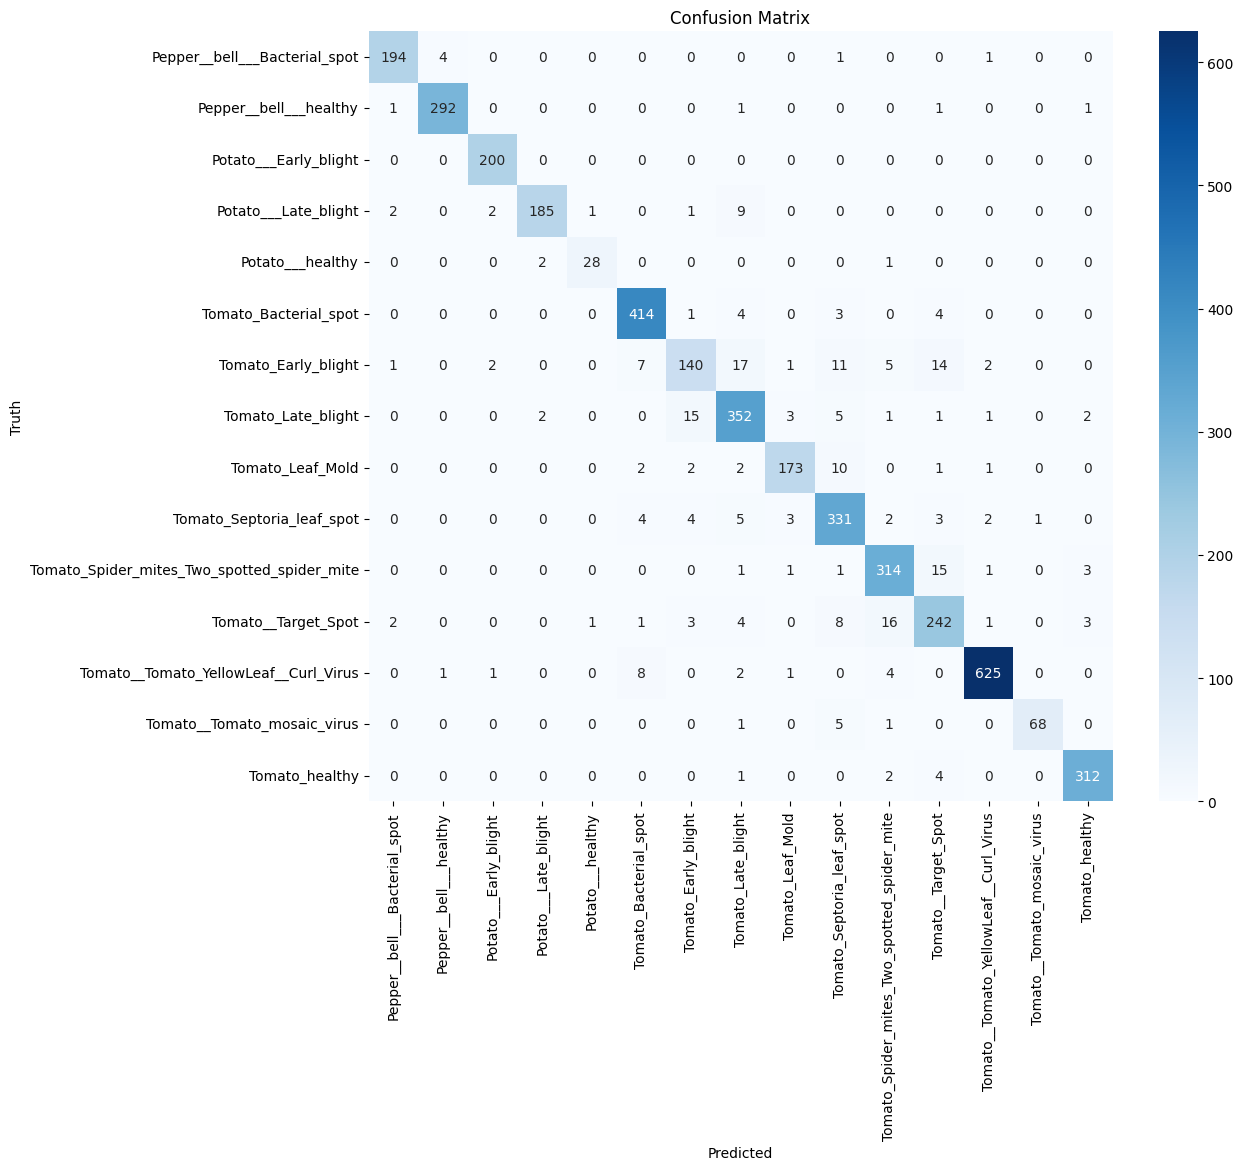

In [54]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True , cmap = "Blues", fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")
plt.show()

In [55]:
print('n\The Classification Report')
print(classification_report(y_true, y_pred, target_names=classes))

n\The Classification Report
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.97      0.97       200
                     Pepper__bell___healthy       0.98      0.99      0.98       296
                      Potato___Early_blight       0.98      1.00      0.99       200
                       Potato___Late_blight       0.98      0.93      0.95       200
                           Potato___healthy       0.93      0.90      0.92        31
                      Tomato_Bacterial_spot       0.95      0.97      0.96       426
                        Tomato_Early_blight       0.84      0.70      0.77       200
                         Tomato_Late_blight       0.88      0.92      0.90       382
                           Tomato_Leaf_Mold       0.95      0.91      0.93       191
                  Tomato_Septoria_leaf_spot       0.88      0.93      0.91       355
Tomato_Spider_mites_Two_spotted_spid

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3912073766.py:1: SyntaxWarning: invalid escape sequence '\T'
  print('n\The Classification Report')


## Better Augmentation

In [5]:
transform_new = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_data1 = datasets.ImageFolder(root=train_dir, transform = transform_new)
val_data1 = datasets.ImageFolder(root=val_dir, transform = transform_new)
test_data1 = datasets.ImageFolder(root=test_dir, transform = transform_new)

## Increased worker numbers

In [8]:
train_loader_new = DataLoader(train_data1, batch_size = 64, shuffle = True, num_workers=4)
val_loader_new = DataLoader(val_data1, batch_size = 64, shuffle = False, num_workers=4)
test_loader_new = DataLoader(test_data1, batch_size = 64, shuffle = False, num_workers=4)

In [9]:
len(train_loader_new) , len(test_loader_new)

(194, 65)

In [13]:
from collections import Counter

class_counts = Counter([train_data1.targets[i] for i in range(len(train_data1))])
class_weights = [1.0 / class_counts[i] for i in range(len(train_data1.classes))]
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

## Unfreezing last layers

In [16]:
model_new = model
print(model_new)
for name , param in model_new.named_parameters():
  if 'layer4' not in name and 'fc' not in name:
    param.requires_grad = False
  else:
    param.requires_grad = True

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Added dropout at final layer

In [17]:
num_classes = len(train_data1.classes)
model_new.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_new.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

In [21]:
model_new = model_new.to(device)

### Introduced Earlystopping for saving time and resources and Learnin Scheduler 

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model_new.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
patience_counter = 0
patience = 5
epochs = 50

for epoch in tqdm(range(epochs)):
  model.train()
  train_loss , train_acc = 0.0 , 0.0
  val_loss , val_acc = 0.0 , 0.0
  correct , total = 0, 0

  for X, y in train_loader_new:

    X , y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = criterion(y_pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct += (y_pred.argmax(1)==y).sum().item()
    total += y.size(0)


  train_acc = 100* correct/total
  train_loss /= len(train_loader_new)


  model.eval()
  with torch.no_grad():
    for X, y in val_loader_new:
      X , y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = criterion(y_pred,y)
      val_loss += loss.item()
      correct = (y_pred.argmax(1)==y).sum().item()
      total = y.size(0)
  val_acc = 100* correct/total
  val_loss /= len(val_loader_new)

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save(model_new.state_dict(), 'best_model.pth')
  else:

    patience_counter += 1

  scheduler.step(val_loss)

  if patience_counter >= patience:
      print(f"Early stopping at epoch {epoch+1}")
      break

  print(f"Epoch [{epoch+1}/{epochs}] | Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Val loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")



  2%|█▋                                                                                 | 1/50 [01:08<55:56, 68.49s/it]

Epoch [1/50] | Train loss: 0.1395 | Train Accuracy: 95.37% | Val loss: 0.2210 | Val Accuracy: 96.77%


  4%|███▎                                                                               | 2/50 [02:16<54:39, 68.32s/it]

Epoch [2/50] | Train loss: 0.1910 | Train Accuracy: 94.03% | Val loss: 0.1693 | Val Accuracy: 93.55%


  6%|████▉                                                                              | 3/50 [03:23<52:51, 67.47s/it]

Epoch [3/50] | Train loss: 0.1222 | Train Accuracy: 95.96% | Val loss: 0.1258 | Val Accuracy: 100.00%


  8%|██████▋                                                                            | 4/50 [04:28<51:00, 66.53s/it]

Epoch [4/50] | Train loss: 0.0962 | Train Accuracy: 96.70% | Val loss: 0.1270 | Val Accuracy: 100.00%


 10%|████████▎                                                                          | 5/50 [05:32<49:21, 65.82s/it]

Epoch [5/50] | Train loss: 0.0881 | Train Accuracy: 96.74% | Val loss: 0.1250 | Val Accuracy: 100.00%


 12%|█████████▉                                                                         | 6/50 [06:36<47:50, 65.24s/it]

Epoch [6/50] | Train loss: 0.0769 | Train Accuracy: 97.41% | Val loss: 0.0972 | Val Accuracy: 93.55%


 14%|███████████▌                                                                       | 7/50 [07:41<46:42, 65.18s/it]

Epoch [7/50] | Train loss: 0.0721 | Train Accuracy: 97.37% | Val loss: 0.0946 | Val Accuracy: 100.00%


 16%|█████████████▎                                                                     | 8/50 [08:47<45:36, 65.15s/it]

Epoch [8/50] | Train loss: 0.0687 | Train Accuracy: 97.74% | Val loss: 0.0825 | Val Accuracy: 96.77%


 18%|██████████████▉                                                                    | 9/50 [09:51<44:26, 65.03s/it]

Epoch [9/50] | Train loss: 0.0601 | Train Accuracy: 97.92% | Val loss: 0.0778 | Val Accuracy: 93.55%


 20%|████████████████▍                                                                 | 10/50 [10:56<43:19, 65.00s/it]

Epoch [10/50] | Train loss: 0.0515 | Train Accuracy: 98.40% | Val loss: 0.0972 | Val Accuracy: 100.00%


 22%|██████████████████                                                                | 11/50 [12:01<42:09, 64.85s/it]

Epoch [11/50] | Train loss: 0.0582 | Train Accuracy: 98.06% | Val loss: 0.0736 | Val Accuracy: 100.00%


 24%|███████████████████▋                                                              | 12/50 [13:06<41:07, 64.94s/it]

Epoch [12/50] | Train loss: 0.0470 | Train Accuracy: 98.25% | Val loss: 0.0763 | Val Accuracy: 96.77%


 26%|█████████████████████▎                                                            | 13/50 [14:10<39:56, 64.78s/it]

Epoch [13/50] | Train loss: 0.0383 | Train Accuracy: 98.67% | Val loss: 0.0514 | Val Accuracy: 96.77%


 28%|██████████████████████▉                                                           | 14/50 [15:15<38:54, 64.84s/it]

Epoch [14/50] | Train loss: 0.0480 | Train Accuracy: 98.28% | Val loss: 0.0747 | Val Accuracy: 100.00%


 30%|████████████████████████▌                                                         | 15/50 [16:21<37:53, 64.97s/it]

Epoch [15/50] | Train loss: 0.0451 | Train Accuracy: 98.45% | Val loss: 0.0597 | Val Accuracy: 100.00%


 32%|██████████████████████████▏                                                       | 16/50 [17:25<36:45, 64.87s/it]

Epoch [16/50] | Train loss: 0.0323 | Train Accuracy: 98.75% | Val loss: 0.0578 | Val Accuracy: 96.77%


 34%|███████████████████████████▉                                                      | 17/50 [18:29<35:33, 64.65s/it]

Epoch [17/50] | Train loss: 0.0562 | Train Accuracy: 98.30% | Val loss: 0.0516 | Val Accuracy: 100.00%


 34%|███████████████████████████▉                                                      | 17/50 [19:35<38:01, 69.12s/it]

Early stopping at epoch 18


In [27]:
model.eval()

y_true , y_pred = [], []

with torch.no_grad():
  for X , y in test_loader_new:
    X,y = X.to(device), y.to(device)
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)

    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = 100 *(y_true == y_pred).mean().sum() 
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 98.77%


### Test accuracy increased from 93.61% to 98.77% after fine-tuning

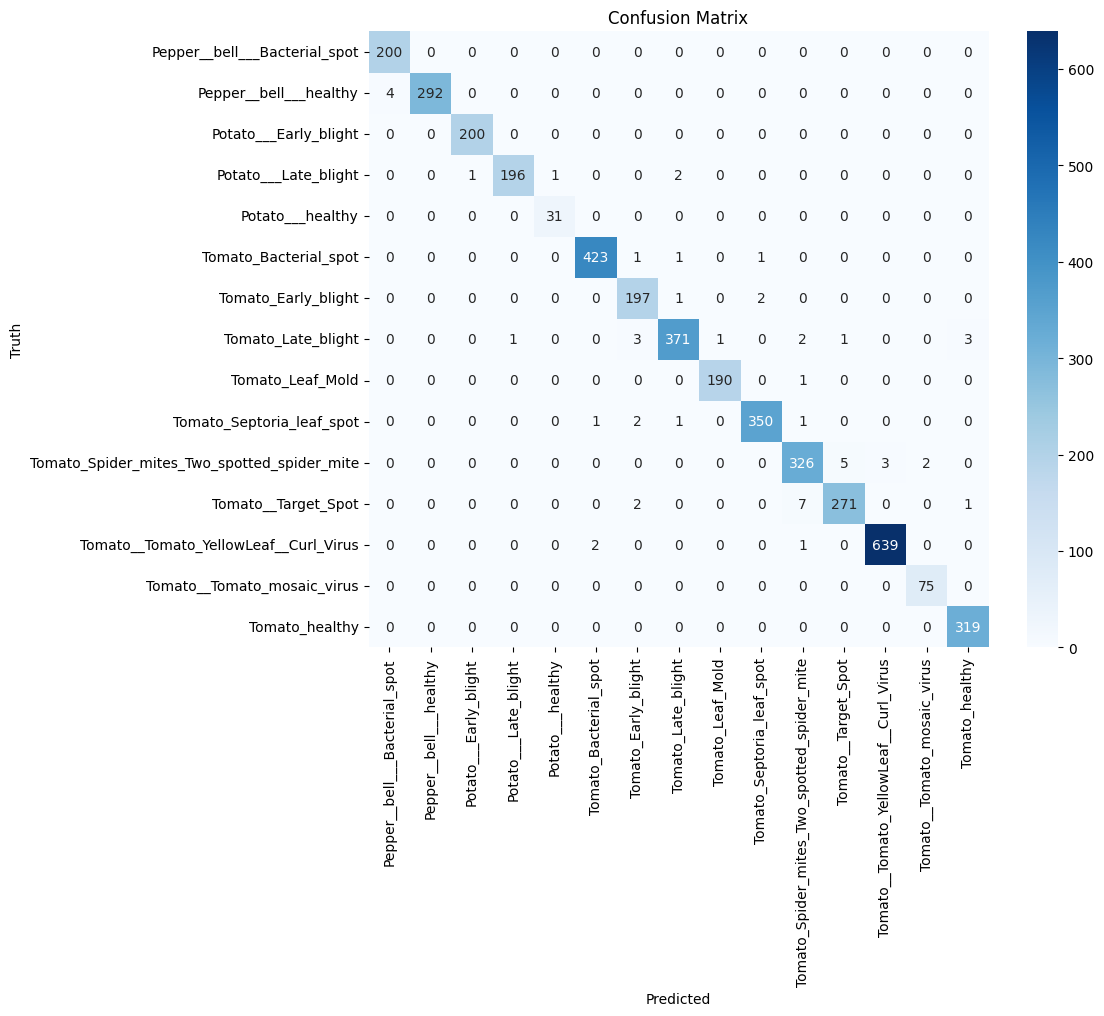

In [25]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True , cmap = "Blues", fmt = 'd', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")
plt.show()